# Comparing Attribution Methods
In the following, some implemented attribution methods are evaluated on a example image. To do so,
* The model and the input are prepared
* The attribution methods are initialized
* The attribution maps are generated for the example input
* The attribution maps are visualized

## Load a Model and Normalize an Example Input

In [1]:
import torch
from torchvision import models, transforms
from attribution_bottleneck.utils.misc import prepare_image
from PIL import Image

device = "cuda"  # Change to "cuda" to run on GPU
model = models.resnet50(pretrained=True).eval()
ex_image = Image.open("monkeys.jpg")
ex_input = prepare_image(ex_image)
ex_target = 382  # 382 is squirrel monkey

## Initialize Attribution Methods

In [2]:
from attribution_bottleneck.attribution import *

methods = {
    "Saliency": Saliency(model),
    "SmoothGrad": SmoothGrad(Saliency(model)),
    "Guided Backprop": GuidedBackprop(model),
    "GradCAM": GradCAM(model, layer=model.layer4),
    "Guided GradCAM": GuidedGradCAM(model, gradcam_layer=model.layer4),
    "Occlusion 14x14": Occlusion(model, 14),
}

In [3]:
from attribution_bottleneck.bottleneck.estimator import ReluEstimator
from attribution_bottleneck.attribution.per_sample_bottleneck import PerSampleBottleneckReader

estim = ReluEstimator(model.layer2)
estim.load("weights/estimator_resnet50_2.torch")
methods["Per-Sample Bottleneck"] = PerSampleBottleneckReader(model, estim)

## Generate and Normalize Heatmaps
To visualize the generated heatmaps, we need to normalize them to [0,1].
We use the simplest possible visualization in this script, a matplotlib "jet" colormap.

In [4]:
heatmaps = {name:method.heatmap(ex_input, ex_target) for name, method in methods.items()}
heatmaps_normalized = {name:heatmap / (heatmap.max()+1e-4) for name, heatmap in heatmaps.items()}

## Compare Heatmap Images

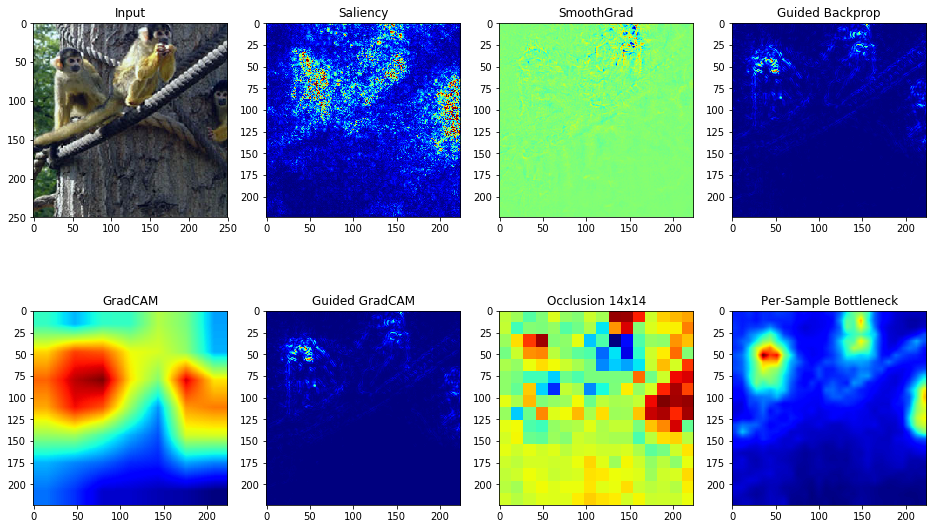

In [5]:
from attribution_bottleneck.utils.misc import show_img
import numpy as np
import matplotlib.pyplot as plt

demo_images = {
    "Input":np.asarray(ex_image),
    **heatmaps
}

rows = len(demo_images)//4 + 1
plt.figure(figsize=(16,rows*5))
for i, (name, image) in enumerate(demo_images.items()):
    plt.subplot(rows, 4, i+1)
    plt.imshow(image, cmap="jet")
    plt.title(name)